# Create animation

This notebook creates timeseries animations of model predictions

#### First load the change in fields data

In [3]:
import pandas as pd
change_in_fields = pd.read_pickle('tmp_data/change_in_fields.pkl')

In [33]:

#This is the same as defined in notebook 2
def load_predictions(model):

    """For this model, load the predictions and determine the prediction error"""
    
    df = pd.read_parquet(model+'predictions.parquet')
    
    #Calculate some extra columns
    df['predicion_bias'] = df.MODIS_LST - df.predictions
    df['predicion_error'] = abs(df.MODIS_LST - df.predictions)
    df['relative_error'] = abs(df.MODIS_LST - df.predictions) / df.MODIS_LST



    print("Mean/Median/Std prediction bias:", df['predicion_bias'].mean(), df['predicion_bias'].median(),df['predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['predicion_error'].mean(), df['predicion_error'].median(),df['predicion_error'].std())

    #Average predictions and errors over the year
    df_grouped = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() 


    return df,df_grouped


#### Then load the model predictions

In [34]:
V15_model =  '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V15_2016_augmented/'
V20_model =  '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_2016_augmented/'
V20X_model = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/V20_2016_augmented_monthlyclake/'


print ('----------V15----------')
V15_predictions,V15_predictions_averaged = load_predictions(V15_model) #averaged = averaged over the year
print ('----------V20----------')
V20_predictions,V20_predictions_averaged = load_predictions(V20_model)
print ('----------V20X----------')
V20X_predictions,V20X_predictions_averaged = load_predictions(V20X_model)

----------V15----------
Mean/Median/Std prediction bias: -0.041747708 0.10055542 4.081224
Mean/Median/Std prediction error: 3.0393808 2.3208313 2.7240207
----------V20----------
Mean/Median/Std prediction bias: 0.13015294 0.26712036 4.0542684
Mean/Median/Std prediction error: 3.0233936 2.3095398 2.7042806
----------V20X----------
Mean/Median/Std prediction bias: 0.018071566 0.15356445 3.9607246
Mean/Median/Std prediction error: 2.9511783 2.2535706 2.6416352


#### Now make a single dataframe which holds the non-averaged data.

In [44]:
V15 =  V15_predictions[['latitude_ERA', 'longitude_ERA', 'time','predicion_error']].copy()
V20 =  V20_predictions[['latitude_ERA', 'longitude_ERA', 'time','predicion_error']].copy()
V20X = V20X_predictions[['latitude_ERA', 'longitude_ERA', 'time','predicion_error']].copy()

In [45]:
V15['model'] = 'V15'
V20['model'] = 'V20'
V20X['model'] = 'V20X'

In [46]:
df_timeseries = pd.concat([V15,V20,V20X])

#### Join on the category data via a mask

We mask then join as it seems to be cheaper...

In [60]:
condition = 'abs(change_in_cl) > 0.1'
#condition = 'bitstring == "010100"'
mask = change_in_fields.query(condition)
df_timeseries_categorized = pd.merge(df_timeseries,mask,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude', 'longitude']) #inner join.



In [61]:
df_timeseries_categorized['month'] = pd.DatetimeIndex(df_timeseries_categorized.time).month
df_timeseries_categorized['day'] = pd.DatetimeIndex(df_timeseries_categorized.time).date

#### And now we can plot a timeseries of a subset of that data

In [62]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.colors as mc
import matplotlib.colorbar as cb
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import seaborn as sns

import sys




def plot_timeseries(df,savefig):

    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))

    p = sns.lineplot(data=df, x="month", y='predicion_error',hue='model', style='model', ci=99,ax=ax1,markers=True)
    ax1.set_xlabel("Month",fontsize=34)
    ax1.set_ylabel("Mean Prediction Error (K)",fontsize=34)
    ax1.legend().set_title(None)
    
    ax1.tick_params(labelsize=30)
    #cax.set_xlabel(r'$\delta$K',fontsize=34)

    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)    
    


    

In [63]:
df_timeseries_categorized = df_timeseries_categorized.reset_index()

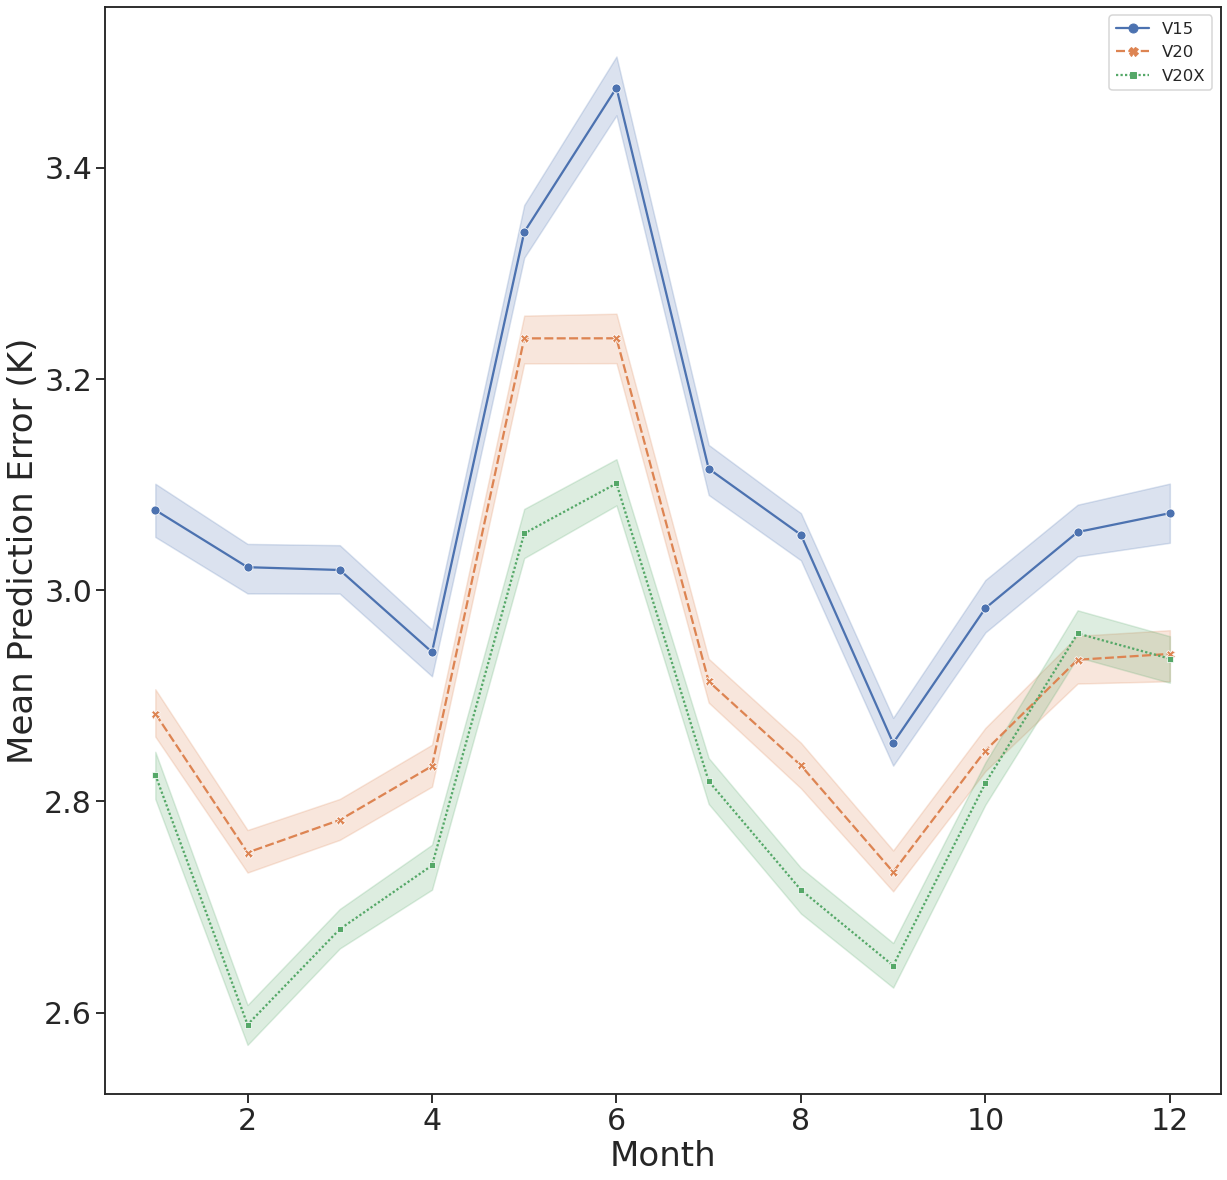

In [64]:
#plot_timeseries(df_timeseries_categorized,'figs/example_timeseries.png')
plot_timeseries(df_timeseries_categorized,savefig=None)

---

In [ ]:
monthlyV15           = monthly_p01[['latitude_ERA','longitude_ERA', 'month', 'V15_error']].copy()
monthlyV15           = monthlyV15.rename(columns={'V15_error':'error'})
monthlyV15['model']  = 'V15'

monthlyV20           = monthly_p01[['latitude_ERA','longitude_ERA', 'month', 'V20_error']].copy()
monthlyV20           = monthlyV20.rename(columns={'V20_error':'error'})
monthlyV20['model']  = 'V20'

monthlyV20X          = monthly_p01[['latitude_ERA','longitude_ERA', 'month', 'V20X_error']].copy()
monthlyV20X          = monthlyV20X.rename(columns={'V20X_error':'error'})
monthlyV20X['model'] = 'V20X'

In [ ]:
dfs_monthly = pd.concat([monthlyV15, monthlyV20, monthlyV20X])


In [ ]:
h,w = 20,20

sns.set_theme(context='talk', 
              style='ticks', 
              palette='deep',
              rc={'figure.figsize':(h,w)}
              )

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(h,w))

p = sns.lineplot(data=dfs_monthly.reset_index(), x="month", y='error',hue='model', style='model', ci=99,ax=ax1,markers=True)
ax1.set_xlabel("Month")
ax1.set_ylabel("Mean Prediction Error (K)")
ax1.legend().set_title(None)
savefig='figures/Timeseries_p01.png'


In [ ]:
V15_2016_X